<a href="https://colab.research.google.com/github/charleygros/IMAS_MachineLearning_Workshop-Image_Analysis/blob/main/code/practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Google Colab with GitHub

In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

%matplotlib notebook

import torchvision
import torch
from torch.utils.data import DataLoader

In [2]:
pwd

'/content'

In [3]:
from google.colab import drive
drive.mount("/content/gdrive/")

path_github = "IMAS_MachineLearning_Workshop-Image_Analysis"
if not os.path.isdir(path_github):
    !git clone https://github.com/charleygros/IMAS_MachineLearning_Workshop-Image_Analysis.git

%cd IMAS_MachineLearning_Workshop-Image_Analysis/code/

!git fetch
!git pull origin main

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
/content/IMAS_MachineLearning_Workshop-Image_Analysis/code
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 20 (delta 5), reused 20 (delta 5), pack-reused 0
Unpacking objects: 100% (20/20), done.
From https://github.com/charleygros/IMAS_MachineLearning_Workshop-Image_Analysis
   4276e97..3d95809  main       -> origin/main
From https://github.com/charleygros/IMAS_MachineLearning_Workshop-Image_Analysis
 * branch            main       -> FETCH_HEAD
Updating 4276e97..3d95809
Fast-forward
 code/utils.py               |   7 ++++---
 dataset/images/016.jpg      | Bin 0 -> 1497404 bytes
 dataset/images/031.jpg      | Bin 0 -> 3181574 bytes
 dataset/images/032.jpg      | Bin 0 -> 4188908 bytes
 dataset/images/033.jpg      | Bin 0 -> 924205 bytes
 dataset/images/034.

In [4]:
from utils import get_fname_list, get_annotation_info, create_binary_mask, imshow_tensor
from loader import WaldoLoader
from model import Waldo_UNet
from training import train_model
from data_augmentation import Sequence, RandomHorizontalFlip, RandomTranslate

In [5]:
path_dataset_folder = "../dataset"
path_image_folder = "images"
fname_annotation = "annotations.csv"
extension = ".jpg"
ratio_train_dataset = 0.75
int_seed_split = 7109
size_patch = 240
sequence_data_augmentation = Sequence([RandomTranslate(0.2)], probs=0.5) # RandomHorizontalFlip()
size_batch = 16

In [6]:
list_fname_im = get_fname_list(root=os.path.join(path_dataset_folder, path_image_folder),
                               extension=extension)
print("Found {} images in the dataset...".format(len(list_fname_im)))

Found 34 images in the dataset...


In [7]:
print("Getting annotations...")
df_annotations = get_annotation_info(path=os.path.join(path_dataset_folder, fname_annotation))
print(df_annotations.head())

Getting annotations...
  filename  width  height  class  xmin  ymin  xmax  ymax
0  001.jpg   2048    1251  waldo   706   513   743   562
1  002.jpg   1286     946  waldo    82   521   107   554
2  003.jpg   2048    1346  waldo  1390   463  1422   500
3  004.jpg   2048    1272  waldo  1484   279  1507   306
4  005.jpg   2100    1760  waldo   882   594   913   634


In [30]:
print("Saving binary mask from annotations as ground-truth...")
for fname_im in list(df_annotations["filename"].unique()):
    fname_gt = fname_im.split(extension)[0] + "_gt.png"
    path_gt = os.path.join(path_dataset_folder, path_image_folder, fname_gt)
    #if not os.path.isfile(path_gt):
    print("... Ground-truth of: {} ...".format(fname_im))
    df_cur = df_annotations[df_annotations["filename"]==fname_im]
    mask = create_binary_mask(list_bbox_coords=df_cur[["xmin", "ymin", "xmax", "ymax"]].values.tolist(),
                          im_ref_width=df_cur["width"].values.tolist()[0],
                          im_ref_height=df_cur["height"].values.tolist()[0])
    plt.imsave(path_gt, mask, cmap='gray')

Saving binary mask from annotations as ground-truth...
... Ground-truth of: 001.jpg ...


AttributeError: ignored

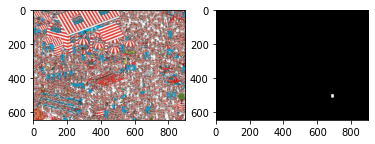

In [9]:
fig = plt.figure()

plt.subplot(1, 2, 1)
im = Image.open(os.path.join(path_dataset_folder, path_image_folder, fname_im))
np_im = np.array(im)
plt.imshow(np_im)

plt.subplot(1, 2, 2)
gt = Image.open(os.path.join(path_dataset_folder, path_image_folder, fname_im.split(".jpg")[0] + "_gt.png"))
np_gt = np.array(gt)
plt.imshow(np_gt)

plt.show()

In [10]:
print("Splitting dataset between Training / Validation / Testing...")
df_fname = df_annotations.drop_duplicates("filename")["filename"]
df_fname_train, df_fname_validate = \
    np.split(df_fname.sample(frac=1, random_state=int_seed_split), [int(ratio_train_dataset*len(df_fname))])
df_annotations["subset"] = "training"
df_annotations.loc[df_annotations["filename"].isin(df_fname_validate), "subset"] = "validation"

print(df_annotations.head())

Splitting dataset between Training / Validation / Testing...
  filename  width  height  class  xmin  ymin  xmax  ymax      subset
0  001.jpg   2048    1251  waldo   706   513   743   562    training
1  002.jpg   1286     946  waldo    82   521   107   554    training
2  003.jpg   2048    1346  waldo  1390   463  1422   500    training
3  004.jpg   2048    1272  waldo  1484   279  1507   306  validation
4  005.jpg   2100    1760  waldo   882   594   913   634    training


In [11]:
width_largest = df_annotations["width"].max()
height_ = df_annotations[df_annotations["width"] == width_largest]["height"].tolist()[0]
size_img = (width_largest, height_)

In [15]:
list_fname_train = df_annotations[df_annotations["subset"] == "training"]["filename"]
list_path_img_train = sorted([os.path.join(path_dataset_folder, path_image_folder, i) for i in list_fname_train])
list_path_gt_train = sorted([p.split(extension)[0] + "_gt.png" for p in list_path_img_train])
dataset_train = WaldoLoader(list_path_img=list_path_img_train,
                            list_path_gt=list_path_gt_train,
                            size_img=size_img,
                            size_patch=size_patch,
                            balance_positive=True,
                            sequence_transforms=sequence_data_augmentation)

Resizing all images to same dimensions: (2953, 2088) pixels^2 ...


In [12]:
list_fname_valid = df_annotations[df_annotations["subset"] == "validation"]["filename"]
list_path_img_valid = sorted([os.path.join(path_dataset_folder, path_image_folder, i) for i in list_fname_valid])
list_path_gt_valid = sorted([p.split(extension)[0] + "_gt.png" for p in list_path_img_valid])
dataset_valid = WaldoLoader(list_path_img=list_path_img_valid,
                            list_path_gt=list_path_gt_valid,
                            size_img=size_img,
                            size_patch=size_patch,
                            balance_positive=True,
                            sequence_transforms=None)

Resizing all images to same dimensions: (2953, 2088) pixels^2 ...


In [16]:
len(dataset_train), len(dataset_valid)

(2574, 1053)

In [17]:
loader_train = DataLoader(dataset_train, batch_size=size_batch, shuffle=True)
loader_valid = DataLoader(dataset_valid, batch_size=size_batch, shuffle=True)

tensor(3.7970e-09) tensor(1.0000)
tensor([0., 1.], dtype=torch.float64) torch.Size([16, 1, 240, 240]) torch.Size([16, 3, 240, 240])


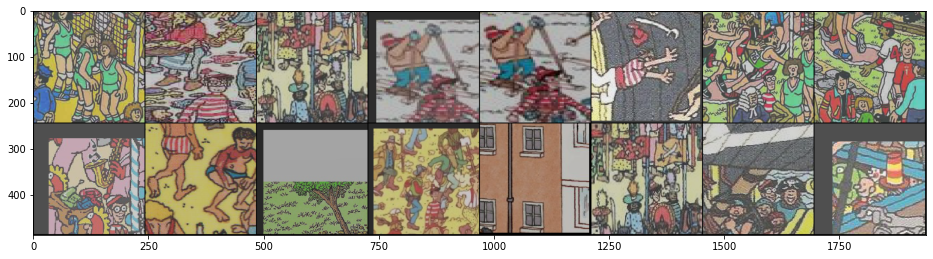

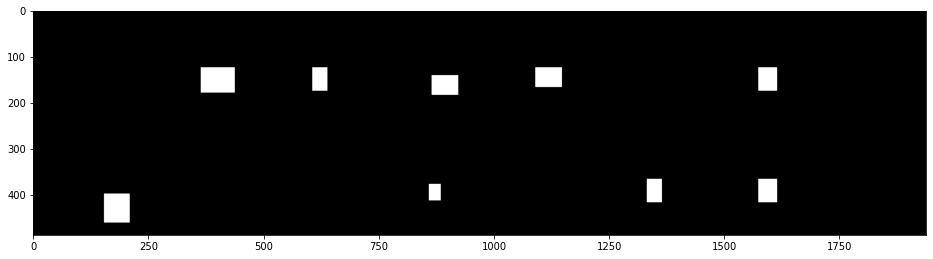

In [18]:
image_expl, label_expl = iter(loader_train).next()
print(image_expl.mean(), image_expl.std())
print(label_expl.unique(), label_expl.size(), image_expl.size())
plt.subplots(figsize=(16, 16))
imshow_tensor(torchvision.utils.make_grid(image_expl, normalize=True))
plt.subplots(figsize=(16, 16))
imshow_tensor(torchvision.utils.make_grid(label_expl))

In [19]:
model = Waldo_UNet(n_channels=3).cuda()
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.006)

In [20]:
model_trained = train_model(model,optimizer, loader_train, dataset_validation=loader_valid, n_epoch=15)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch#1 -- Train loss: -0.01 -- Validation loss: -0.004
Epoch#2 -- Train loss: -0.011 -- Validation loss: -0.003
Epoch#3 -- Train loss: -0.003 -- Validation loss: -0.004
Epoch#4 -- Train loss: -0.003 -- Validation loss: -0.003
Epoch#5 -- Train loss: -0.009 -- Validation loss: -0.001
Epoch#6 -- Train loss: -0.01 -- Validation loss: -0.006
Epoch#7 -- Train loss: -0.052 -- Validation loss: 0.0
Epoch#8 -- Train loss: -0.008 -- Validation loss: 0.075
Epoch#9 -- Train loss: -0.009 -- Validation loss: -0.002
Epoch#10 -- Train loss: -0.003 -- Validation loss: -0.003
Epoch#11 -- Train loss: 0.012 -- Validation loss: -0.004
Epoch#12 -- Train loss: -0.009 -- Validation loss: -0.008
Epoch#13 -- Train loss: -0.028 -- Validation loss: -0.035
Epoch#14 -- Train loss: -0.045 -- Validation loss: -0.003
Epoch#15 -- Train loss: -0.004 -- Validation loss: -0.003


In [ ]:
921600 * 2